In [1]:
%matplotlib inline
from cox import readers
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

In [2]:
r = readers.CollectionReader('agents')

100%|██████████| 320/320 [00:25<00:00, 12.49it/s]


In [3]:
metadata = r.df('metadata')
opt = r.df('optimization')
opt['opt_step'] = opt.index
#nadv = r.df('normalized_advantage')
#nadv['opt_step'] = (nadv.index % 50) * 10
#constraints = r.df('paper_constraints_train')
#constraints_heldout = r.df('paper_constraints_heldout')

In [4]:
games =  ["Walker2d-v2", "Humanoid-v2", "Swimmer-v2", "Hopper-v2"]
code_level_opts = {
      #'kl_penalty_coeff': [3, 0.0],
      'kl_penalty_direction': ['new_to_old', 'old_to_new'],
      'anneal_kl_penalty_coeff': [True, False]
      #'clip_advantages': [1e8],
      #'norm_rewards': ['none', 'returns'],
      #'anneal_lr': [False, True],
      #'value_clipping': [False, True],
      #'initialization': ['xavier', 'orthogonal']
}

NUM_BINS = 20

In [5]:
key_metadata = metadata[['exp_id', 'game'] + list(code_level_opts.keys())]
#constraints = constraints.merge(key_metadata, on='exp_id')
#constraints_heldout = constraints_heldout.merge(key_metadata, on='exp_id')
#nadv = nadv.merge(key_metadata, on='exp_id')
opt = opt.merge(key_metadata, on='exp_id')

# Plot max rewards

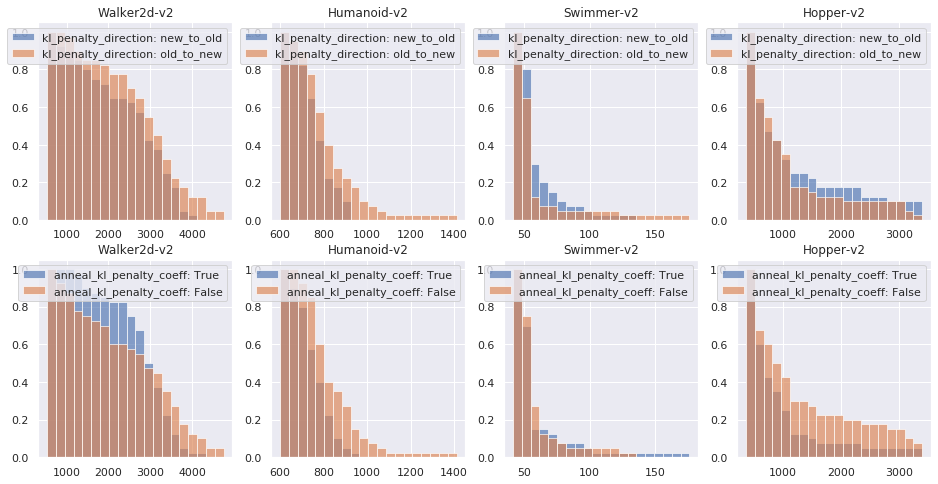

In [7]:
max_rewards = opt.groupby(['exp_id', 'game'] + list(code_level_opts.keys())).max()
max_rewards = max_rewards.reset_index()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.game == g][
        'mean_reward'].tolist(), NUM_BINS)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for i, cl_opt in enumerate(code_level_opts):
        for b in code_level_opts[cl_opt]:
            filt = max_rewards[(max_rewards[cl_opt] == b) & (max_rewards.game == g)]
            hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            ax[i][j].bar(bin_locs, hist, label=f"{cl_opt}: {b}", **kwargs)
        ax[i][j].legend()
        ax[i][j].set_title(g)
plt.show()

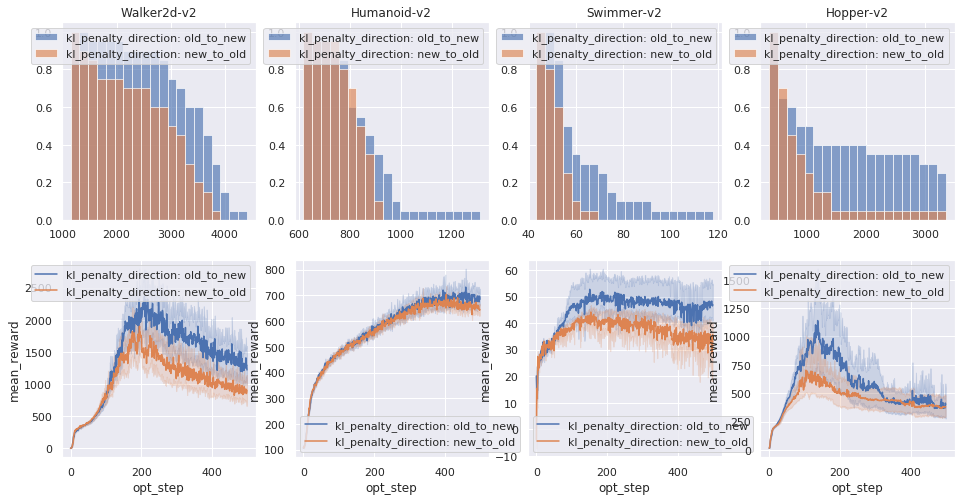

In [55]:
max_rewards = opt.groupby('exp_id').max()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    exp_ids_game = set(metadata[(metadata.game == g) & (metadata.kl_penalty_coeff > 0)]['exp_id'].tolist())
    max_rewards_game = max_rewards[max_rewards.index.isin(exp_ids_game)]
    opt_game = opt[opt.index.get_level_values(0).isin(exp_ids_game)]
    
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.index.isin(exp_ids_game)][
        'mean_reward'].tolist(), NUM_BINS)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for cl_opt in ['kl_penalty_direction']:
        for b in reversed(code_level_opts[cl_opt]):
            exp_ids = set(metadata[(metadata[cl_opt] == b)]['exp_id'].tolist())
            filt = max_rewards_game[max_rewards_game.index.isin(exp_ids)]
            hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            ax[0][j].bar(bin_locs, hist, label=f"{cl_opt}: {b}", **kwargs)
            
            filt = opt_game[opt_game.index.get_level_values(0).isin(exp_ids)]
            sns.lineplot(filt.index.get_level_values(1), filt.mean_reward,
                         ax=ax[1][j], label=f"{cl_opt}: {b}")
        ax[0][j].legend()
        ax[0][j].set_title(g)
plt.show()

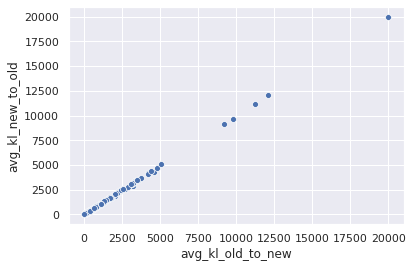

In [79]:
sns.scatterplot(constraints_heldout[constraints_heldout.kl_penalty_coeff > 0].avg_kl_old_to_new,
                constraints_heldout[constraints_heldout.kl_penalty_coeff > 0].avg_kl_new_to_old)

In [84]:
from scipy.stats.stats import pearsonr   
print(pearsonr(constraints.avg_kl_old_to_new, constraints.avg_kl_new_to_old))
print(pearsonr(constraints_heldout.avg_kl_old_to_new, constraints_heldout.avg_kl_new_to_old))

(0.9999847477487321, 0.0)
(0.9999848580098782, 0.0)


# Advantage Distribution

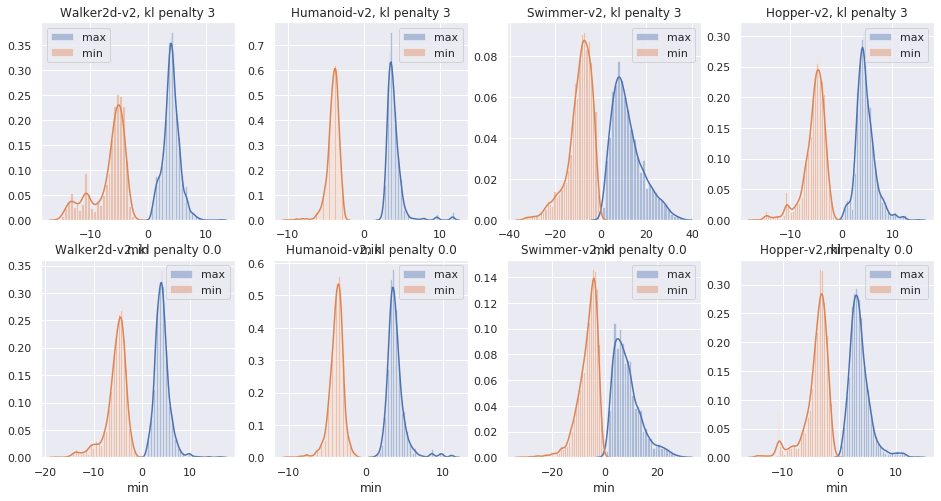

In [97]:
# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    for i, c in enumerate(code_level_opts['kl_penalty_coeff']):    
        filt = nadv[(nadv.game == g) & (nadv.kl_penalty_coeff == c)]
        sns.distplot(filt['max'], ax=ax[i][j], label='max')
        sns.distplot(filt['min'], ax=ax[i][j], label='min')
        ax[i][j].legend()
        ax[i][j].set_title(str(g) + ', kl penalty ' + str(c))

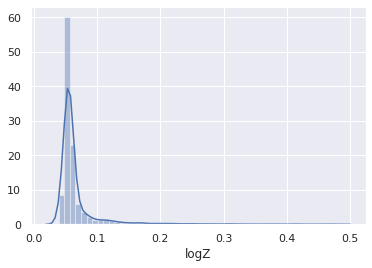

In [112]:
eta = 1.0/3.0
kurt = nadv[nadv.kl_penalty_coeff == 3]['kurtosis']
sk = nadv[nadv.kl_penalty_coeff == 3]['skewness']
nadv['logZ'] = np.log(1 + eta ** 2 / 2.0 + eta ** 3 / 6.0 * sk + eta ** 4 * kurt / 24)
sns.distplot(nadv['logZ'].dropna())

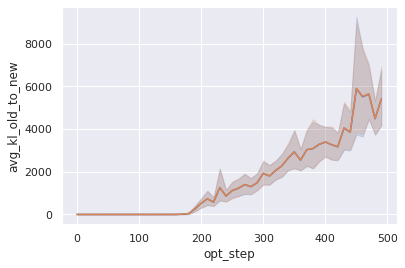

In [114]:
sns.lineplot(x=constraints_heldout['opt_step'], y=constraints_heldout['avg_kl_new_to_old'])
sns.lineplot(x=constraints_heldout['opt_step'], y=constraints_heldout['avg_kl_old_to_new'])
plt.show()

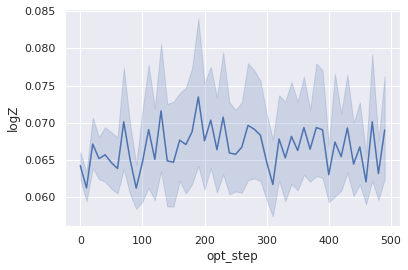

In [115]:
sns.lineplot(x=nadv['opt_step'], y=nadv['logZ'])
plt.show()

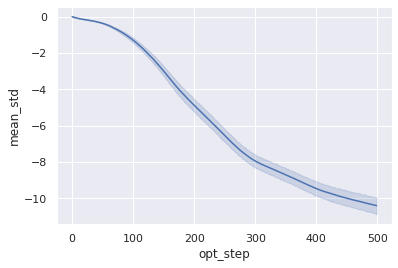

In [130]:
sns.lineplot(x=opt['opt_step'], y=np.log(opt['mean_std']))
plt.show()

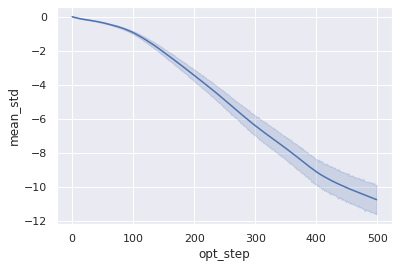

In [131]:
sns.lineplot(x=opt[opt.kl_penalty_coeff == 3]['opt_step'],
             y=np.log(opt[opt.kl_penalty_coeff == 3]['mean_std']))
plt.show()

# Aggregate performance (max over learning rates, avg over trials)

In [18]:
ks = ['game'] + list(code_level_opts.keys())
grouped_1 = max_rewards.merge(metadata, on='exp_id').groupby(ks).mean().reset_index().set_index(ks)
grouped_1

mean_reward  \
game        kl_penalty_coeff kl_penalty_direction                
Hopper-v2   0.0              new_to_old            1008.849510   
                             old_to_new             897.428451   
            3.0              new_to_old             852.524733   
                             old_to_new            1572.491131   
Humanoid-v2 0.0              new_to_old             646.094015   
                             old_to_new             650.384142   
            3.0              new_to_old             820.192148   
                             old_to_new             861.827004   
Swimmer-v2  0.0              new_to_old              96.860444   
                             old_to_new              83.472788   
            3.0              new_to_old              51.687640   
                             old_to_new              61.970908   
Walker2d-v2 0.0              new_to_old            2390.217288   
                             old_to_new            2363.513727   
            3.0              new_to_old            2687.871417   
                             old_to_new            3349.710840   

                                                   final_value_loss  mean_std  \
game        kl_penalty_coeff kl_penalty_direction                               
Hopper-v2   0.0              new_to_old                    0.566093  0.998760   
                             old_to_new                    0.521543  0.992144   
            3.0              new_to_old                    0.562497  0.993679   
                             old_to_new                    0.534869  0.994834   
Humanoid-v2 0.0              new_to_old                    2.325031  0.998954   
                             old_to_new                    2.528731  0.997403   
            3.0              new_to_old                    2.090004  1.000973   
                             old_to_new                    2.056217  1.001805   
Swimmer-v2  0.0              new_to_old                    0.983801  0.996794   
                             old_to_new                    0.889860  0.987482   
            3.0              new_to_old                    0.781625  0.984274   
                             old_to_new                    1.042065  0.997104   
Walker2d-v2 0.0              new_to_old                    0.750027  0.995695   
                             old_to_new                    0.497386  0.995893   
            3.0              new_to_old                    0.485312  0.994554   
                             old_to_new                    0.365133  0.995612   

                                                   num_minibatches  \
game        kl_penalty_coeff kl_penalty_direction                    
Hopper-v2   0.0              new_to_old                         32   
                             old_to_new                         32   
            3.0              new_to_old                         32   
                             old_to_new                         32   
Humanoid-v2 0.0              new_to_old                         32   
                             old_to_new                         32   
            3.0              new_to_old                         32   
                             old_to_new                         32   
Swimmer-v2  0.0              new_to_old                         32   
                             old_to_new                         32   
            3.0              new_to_old                         32   
                             old_to_new                         32   
Walker2d-v2 0.0              new_to_old                         32   
                             old_to_new                         32   
            3.0              new_to_old                         32   
                             old_to_new                         32   

                                                   num_actors  norm_states  \
game        kl_penalty_coeff kl_penalty_direction               